In [597]:
# System libraries
import sys, os, gc
import datetime

# Math libraries
import math, random
import pandas as pd, numpy as np
import scipy
from scipy import stats
from datetime import timedelta
from datetime import datetime
import itertools

# Data storage libraries
import pickle, sqlite3, simpledbf, boto3

# Custom financial data libraries
import findata_utils as fd
import ml_utils

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
#if not sys.warnoptions:
#    warnings.simplefilter("ignore")

from importlib import reload
fd = reload(fd)

import sklearn as sk
import tensorflow as tf
import xgboost as xgb
import keras

from imblearn.over_sampling import RandomOverSampler

from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib 

from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

from yellowbrick.regressor import ResidualsPlot, PredictionError

# Connect to databases
db = 'C:\\Datasets\\thesis.db'
overleaf = ['C:','Users','bryce','OneDrive','Documents','Overleaf','5babbfe264c952737a9a5117','esc499']
conn = sqlite3.connect(db)
c = conn.cursor()

hdf_path = 'C:\\Datasets\\thesis.h5'
hdf = pd.HDFStore(hdf_path)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

## Construct the index market cap

In [774]:
limit = 0.5

index_mkt_cap = pd.read_sql('''SELECT * FROM index_mkt_cap_bbgmethod''', conn)
#index_mkt_cap['threshold'] = index_mkt_cap['SPTSXComp']*0.0004
#index_mkt_cap['lower'] = index_mkt_cap['threshold']*(1-limit)
#index_mkt_cap['upper'] = index_mkt_cap['threshold']*(1+limit)

index_mkt_cap['datetime'] = index_mkt_cap['date'].apply(lambda date: datetime.strptime(str(date)[:10], '%Y-%m-%d'))
index_mkt_cap['month'] = index_mkt_cap['datetime'].apply(lambda date: date.strftime('%Y-%m'))
index_mkt_cap['is_ranking_week'] = index_mkt_cap['datetime'].apply(lambda date: (date+timedelta(days=14)).month!=date.month)

index_mkt_cap.drop(['datetime'],axis=1, inplace=True)

display(index_mkt_cap.head())

avg_mkt_caps = pd.DataFrame(index_mkt_cap.loc[index_mkt_cap['is_ranking_week']].groupby(by=['month'])['mkt_cap'].mean()).reset_index()
display(avg_mkt_caps.head())

,date,price,indexed,mkt_cap,month,is_ranking_week
0,2018-12-31 00:00:00,14322.86,0.879905,7.425816e+11,2018-12,True
1,2018-12-28 00:00:00,14222.00,0.873709,7.373524e+11,2018-12,True
2,2018-12-27 00:00:00,14165.21,0.870220,7.344081e+11,2018-12,True
3,2018-12-24 00:00:00,13780.19,0.846567,7.144464e+11,2018-12,True
4,2018-12-21 00:00:00,13935.44,0.856105,7.224955e+11,2018-12,True


,month,mkt_cap
0,1999-03,3.413876e+11
1,1999-04,3.640760e+11
2,1999-05,3.562301e+11
3,1999-06,3.605815e+11
4,1999-07,3.679413e+11


## Look at marginal securities only

In [775]:
index_changes = pd.read_sql('''
    SELECT date, action, ticker,
        SUBSTR(date,0,8) AS month
    FROM factset_index_changes
    WHERE [index] IN ('{StudyIndex}')
    '''.format(StudyIndex='S&P/TSX Composite Index'), conn)

index_changes['ranking_month'] = index_changes['month'].apply(lambda month: (datetime.strptime(month, '%Y-%m')-timedelta(days=28)).strftime('%Y-%m'))
#tickers = index_changes['ticker'].unique()

px = pd.read_sql('''
    SELECT c.date, c.ticker, c.c, s.shares_out, c.c*s.shares_out AS mkt_cap, c.vol
    FROM cfmrc c
    INNER JOIN shares_out s
        ON s.ticker=c.ticker
    --WHERE mkt_cap>{MinMktCap}*0.75
        --AND c.ticker IN ('{Tickers}')
    '''.format(Tickers='', MinMktCap='')
    , conn)

display(index_changes.head())
display(px.head())

,date,action,ticker,month,ranking_month
0,2019-03-18 00:00:00,Add,SMU.UN,2019-03,2019-02
1,2019-03-18 00:00:00,Add,CJT,2019-03,2019-02
2,2019-03-18 00:00:00,Add,DIR.UN,2019-03,2019-02
3,2019-03-18 00:00:00,Add,AFN,2019-03,2019-02
4,2019-03-18 00:00:00,Add,NWH.UN,2019-03,2019-02


,date,ticker,c,shares_out,mkt_cap,vol
0,2011-09-13,AAA,1.19,0.0,0.0,1307785
1,2011-09-14,AAA,1.15,0.0,0.0,965285
2,2011-09-15,AAA,1.11,0.0,0.0,2612506
3,2011-09-16,AAA,1.13,0.0,0.0,857318
4,2011-09-19,AAA,1.12,0.0,0.0,477393


### Construct a sample of marginal securities

In [776]:
sample = px.merge(index_mkt_cap, on=['date'], how='inner').sort_values(by=['is_ranking_week','date','ticker'],
                                                                      ascending=[False,True,True])

# Only look at the ranking week
sample = sample.loc[sample['is_ranking_week']]# & (sample['mkt_cap'].between(sample['lower'],sample['upper']))]

# Do not look at securities already in the index
indexed = pd.read_sql('SELECT * FROM in_the_comp', conn).set_index(['date']).unstack().reset_index()
indexed.columns = ['ticker','date','indexed']
indexed['indexed'] = indexed['indexed'].replace(1,True).replace(0,False)

# Merge to list of securities already in the index
sample = sample.merge(indexed, on=['date','ticker'], how='left')

# Merge to list of changes
sample = sample.merge(index_changes, left_on=['month','ticker'], 
             right_on=['ranking_month','ticker'], 
             how='outer', suffixes=('','_chg'))
sample.drop(['month_chg'], axis=1, inplace=True)

# Fix dates
sample['date'].fillna(sample['date_chg'],inplace=True)
sample['datetime'] = sample['date'].apply(lambda date: datetime.strptime(str(date)[:10], '%Y-%m-%d'))
sample['month'] = sample['datetime'].apply(lambda date: date.strftime('%Y-%m'))
sample['ranking_month'] = sample['month'].apply(lambda month: (datetime.strptime(str(month), '%Y-%m')-timedelta(days=28)).strftime('%Y-%m'))
sample['is_ranking_week'] = sample['datetime'].apply(lambda date: (date+timedelta(days=14)).month!=date.month)

# Remove some NAs
sample['indexed'].fillna(False, inplace=True)
sample = sample.loc[~sample['vol'].isna()]

# Only look at things which could reasonably change this month
sample = sample.loc[~sample['indexed']]

# Compute some stats
#sample['pct_threshold'] = sample['mkt_cap']/sample['threshold']

display(sample.head())

KeyError: 'indexed'

### Aggregate per ranking period

In [736]:
sample['mkt_cap_X_vol'] = sample['mkt_cap']*sample['vol']
sample['c_X_vol'] = sample['c']*sample['vol']

grouped = sample.groupby(by=['ticker','month'])[['vol','mkt_cap_X_vol', 'c_X_vol']].sum().reset_index()
grouped['VWMC'] = grouped['mkt_cap_X_vol']/grouped['vol']
grouped['VWAP'] = grouped['c_X_vol']/grouped['vol']
grouped.drop(['vol','mkt_cap_X_vol','c_X_vol'], axis=1, inplace=True)

grouped = grouped.merge(avg_mkt_caps, on=['month'], how='outer')

grouped.sort_values(by=['month','ticker'], inplace=True)

#grouped['pct_thresh'] = grouped['VWMC']/grouped['threshold']



grouped = grouped.merge(index_changes, left_on=['month','ticker'],
                        right_on=['ranking_month','ticker'],
                        how='outer', suffixes=('','_chg'))
grouped.drop(['month_chg','ranking_month'], axis=1, inplace=True)

grouped = grouped.loc[grouped['action']!='Delete']
grouped = grouped.loc[~grouped['VWMC'].isna()]

grouped['pct_contribution'] = grouped['VWMC']/(grouped['SPTSXComp'] + grouped['VWMC'])

grouped['add']=grouped['action']=='Add'

display(grouped.head())

,ticker,month,VWMC,VWAP,SPTSXComp,date,action,pct_contribution,add
0,AEM,2010-01,1.269364e+10,54.20,7.001741e+11,NaN,NaN,0.017806,False
1,AEZS,2010-01,1.508800e+07,0.92,7.001741e+11,NaN,NaN,0.000022,False
2,AG.UN,2010-01,1.219044e+09,3.48,7.001741e+11,NaN,NaN,0.001738,False
3,AKG,2010-01,1.357058e+09,6.01,7.001741e+11,NaN,NaN,0.001934,False
4,ALC,2010-01,0.000000e+00,76.25,7.001741e+11,NaN,NaN,0.000000,False


3011 12043
0.9990036532713384
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     12017
        True       0.00      0.00      0.00        26

   micro avg       1.00      1.00      1.00     12043
   macro avg       0.50      0.50      0.50     12043
weighted avg       1.00      1.00      1.00     12043



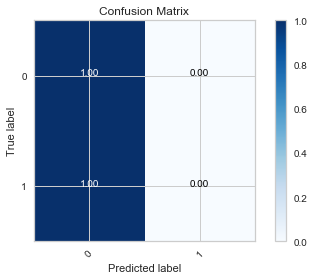

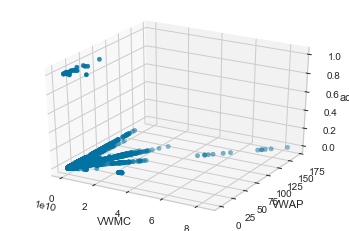

In [761]:
y_col = 'add'
X_cols = ['VWMC','VWAP']
X = grouped[X_cols]
y = grouped[y_col]
SEED=0xDEADBEEF

X_test, X_train, y_test, y_train  = sk.model_selection.train_test_split(X.values, y.values, test_size=0.2, random_state=SEED)

print(len(X_train), len(X_test))

log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

print(log_clf.score(X_train, y_train))

y_pred = log_clf.predict(X_test)
y_pred_prob = log_clf.predict_proba(X_test)
ml_utils.clf_model_eval(y_test, y_pred)
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.values[:,0],X.values[:,1],y.values)
ax.set_xlabel(X_cols[0])
ax.set_ylabel(X_cols[1])
ax.set_zlabel(y_col)
plt.show()

In [771]:
index_changes.loc[index_changes['ticker']=='NTR']

,date,action,ticker,month,ranking_month
694,2002-05-01 00:00:00,Add,NTR,2002-05,2002-04


In [770]:
index_changes

,date,action,ticker,month,ranking_month
0,2019-03-18 00:00:00,Add,SMU.UN,2019-03,2019-02
1,2019-03-18 00:00:00,Add,CJT,2019-03,2019-02
2,2019-03-18 00:00:00,Add,DIR.UN,2019-03,2019-02
3,2019-03-18 00:00:00,Add,AFN,2019-03,2019-02
4,2019-03-18 00:00:00,Add,NWH.UN,2019-03,2019-02
5,2019-03-18 00:00:00,Add,ERO,2019-03,2019-02
6,2019-03-18 00:00:00,Delete,CMG,2019-03,2019-02
7,2019-03-18 00:00:00,Delete,KML,2019-03,2019-02
8,2019-03-18 00:00:00,Delete,LUC,2019-03,2019-02
9,2019-03-18 00:00:00,Add,SMU.UN,2019-03,2019-02


In [765]:
grouped.sort_values(by=['VWAP'], ascending=False)

,ticker,month,VWMC,VWAP,SPTSXComp,date,action,pct_contribution,add
2076,POT,2011-01,8.421935e+10,167.951634,7.888724e+11,NaN,NaN,9.646105e-02,False
1260,POT,2010-08,7.779477e+10,155.139639,6.943343e+11,NaN,NaN,1.007536e-01,False
1425,POT,2010-09,7.551591e+10,150.595091,7.183119e+11,NaN,NaN,9.512883e-02,False
1912,POT,2010-12,7.427822e+10,148.126864,7.992530e+11,NaN,NaN,8.503213e-02,False
1586,POT,2010-10,7.393579e+10,147.443984,7.464336e+11,NaN,NaN,9.012500e-02,False
1748,POT,2010-11,7.254772e+10,144.675876,7.675152e+11,NaN,NaN,8.635986e-02,False
2360,HCH,2011-03,0.000000e+00,133.059918,8.326947e+11,NaN,NaN,0.000000e+00,False
2197,HCH,2011-02,0.000000e+00,132.826845,8.330961e+11,NaN,NaN,0.000000e+00,False
2033,HCH,2011-01,0.000000e+00,129.680993,7.888724e+11,NaN,NaN,0.000000e+00,False
2525,HCH,2011-04,0.000000e+00,127.439687,8.153832e+11,NaN,NaN,0.000000e+00,False
